In [121]:
import numpy as np
import pandas as pd
import re
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.datasets import load_files

nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()

from pylab import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sini\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [123]:
# Eetun funktiot

def tokenizer(words):
    # https://gist.github.com/ajnelson-nist/f93e07fca60d0fb42c5c
    tokens_with_count = Counter(map(str.lower, book_words))
    return tokens_with_count

def token_counter(tokens_with_count):
    tokens = sorted([k for k in tokens_with_count.keys()])
    counts = np.array([tokens_with_count[k] for k in tokens])
    ranks = np.arange(1, len(counts) + 1)
    indices = np.argsort(-counts)
    frequencies = counts[indices]
    return ranks, indices, frequencies

def sw_filter(book_words):
    stop_words = stopwords.words('english')
    stop_words.append('The')
    filtered_words = [w.lower() for w in book_words if not w.lower() in stop_words]
    ftokens_with_count = Counter(map(str.lower, filtered_words))
    topwords = [t[0] for t in ftokens_with_count.most_common(20)]
    doclen = len(ftokens_with_count)
    return filtered_words, ftokens_with_count, topwords, doclen

In [124]:
files = ["flatland.txt", "panama-canal.txt", "ulysses.txt"]
books = []

for f in files:
    file = open(f, "r", encoding='utf-8')
    b = re.findall(r'(\b[A-Za-z][a-z]{2,15}\b)', file.read())
    books.append(b)
    file.close()

tcounts = [] # bag of words
tokens = []
for b in books:
    words, tcs, _, _ = sw_filter(b)
    tokens.append(list(tcs.keys()))
    tcounts.append(tcs)

ranks = []
freqs = []
for tc in tcounts:
    r, _, f = token_counter(tc)
    ranks.append(r)
    freqs.append(f)
    
for i in range(len(books)):
    books[i] = " ".join(books[i]).lower()

In [125]:
books = pd.DataFrame({'book_name': ["flatland", "panama-canal", "ulysses"], 
                      'book_text': books, 'ranks': ranks, 'freqs': freqs, 
                      'tokens': tokens})
books = books.set_index("book_name")
books.head()

,book_text,ranks,freqs,tokens
book_name,,,,
flatland,the nature flatland call our world flatland no...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[151, 107, 94, 90, 82, 81, 80, 75, 73, 71, 70,...","[nature, flatland, call, world, make, clearer,..."
panama-canal,the project gutenberg the panama canal saxon m...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[609, 404, 299, 279, 213, 171, 162, 140, 138, ...","[project, gutenberg, panama, canal, saxon, mil..."
ulysses,produced david widger complete grant man propo...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1524, 1278, 1213, 1110, 1047, 871, 840, 836, ...","[produced, david, widger, complete, grant, man..."


# Task 7.

We would like to test the **Zipf’s law on word categories** instead of the whole set of words. For this purpose, **using the topic of the ebook content, suggest appropriate identification of LIWC category(ies)**; for instance, horror like ebook would entail Psychological process like categories. 

You should notice that LIWC full list of wording is not freely available, so you may use alternatives provided in the lecture handout or suggest your own alternative.

Once appropriate category is found, you should **only construct the frequency graph with respect to words of that category**, and then try to fit the Zipf’s curve distribution. 

If more than one category is found to match the ebook content, **select the category that contains the higher number of words**. Devise appropriate high level description of your implementation -how this has been achieved.


- LIWC alternative categories: http://www.wjh.harvard.edu/~inquirer/homecat.htm

TO-DO:
1. **Discover relevant categories** for each book, ie. categories from General Inquirer
    - How many categories?
    - Clustering to propose categories (or some unsupervised method, attempt LDA or Latent Semantic Analysis (LSA) for one document)
    
2. **Collect words belonging to each category**, e.g. by crawling the web (wikipedia might be enough)
    - (idea: https://stackoverflow.com/questions/4844825/how-to-classify-words-to-their-correspoding-categories)
    
3. Select **most frequent words** for words crawled for each category and exclude stopwords -> related words to each category


4. Classify words in each book to its categories (e.g. KNN)
    - How to deal with word senses? (Answer: do not deal)


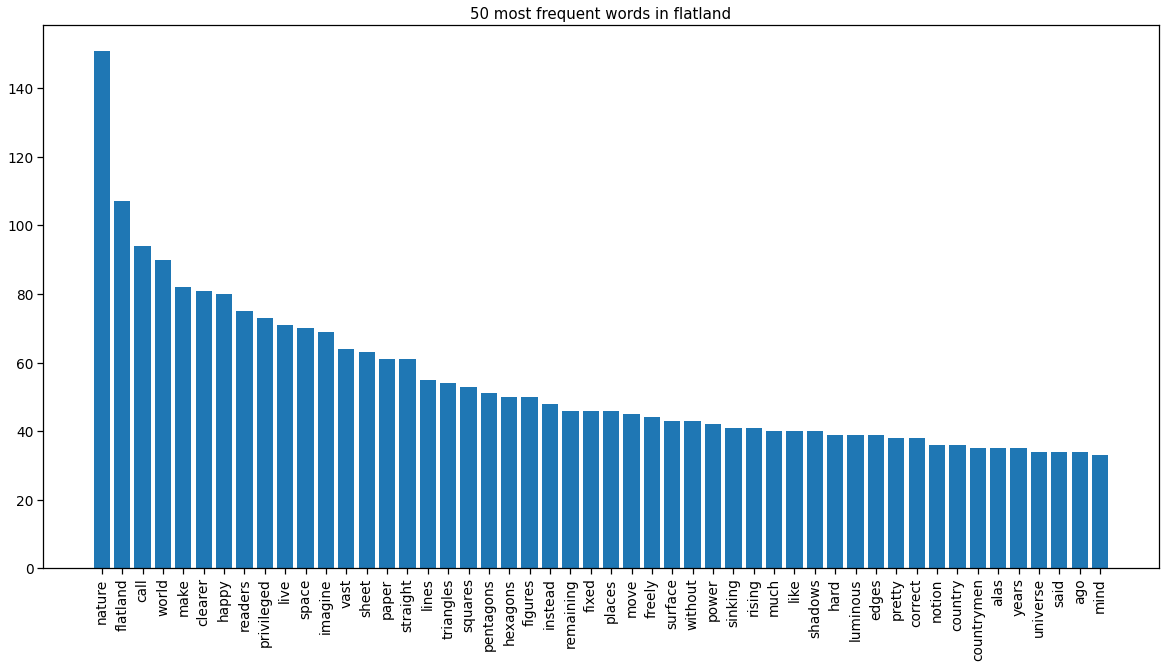

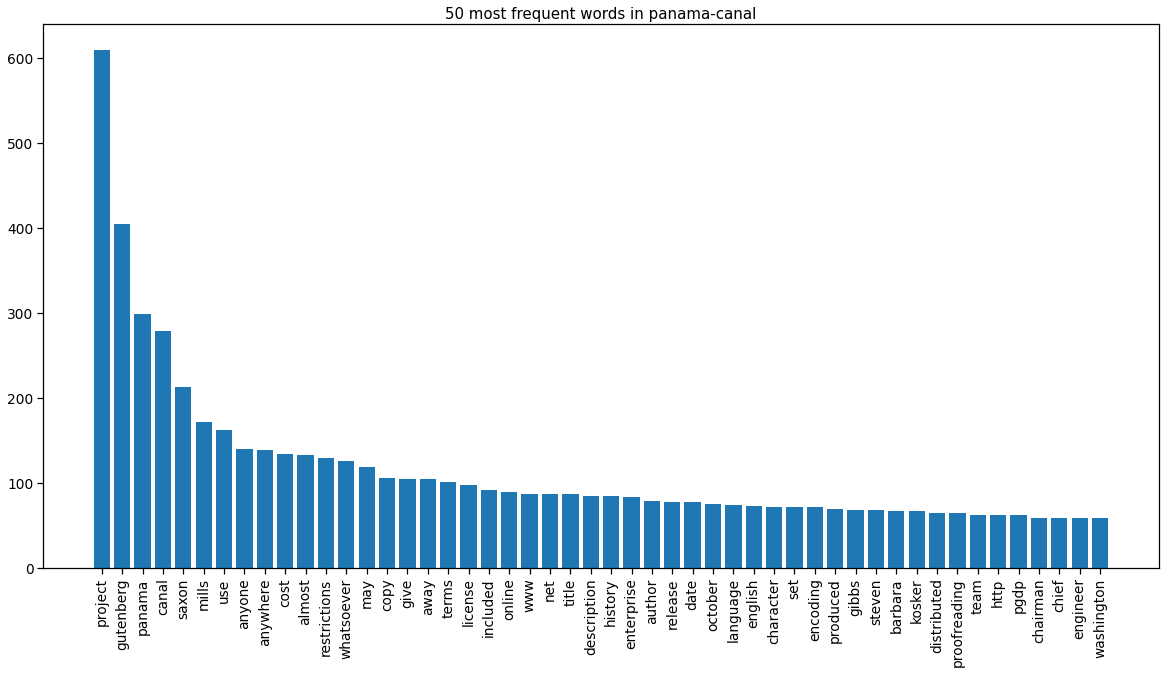

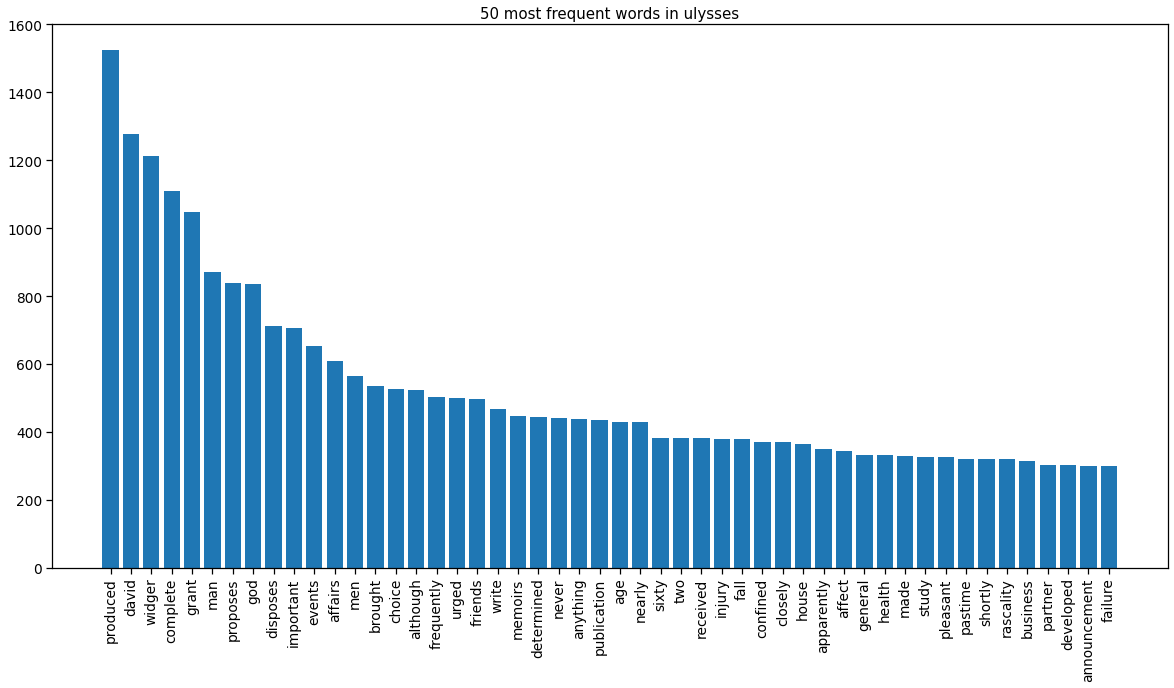

In [128]:
for b in books.index:
    df = pd.DataFrame({'word': books.tokens[b], 'count': books.freqs[b]}).sort_values(by=['count'], ascending=False).head(50)
    #df = df.sort_values(by=['count']) # ascending for plot

    x = list(df.loc[:, 'word'])
    y = list(df.loc[:, 'count'])
    
    plt.figure(figsize=(20,10))
    title("50 most frequent words in " + b)
    plt.bar(x, y)
    plt.xticks(rotation='vertical')
    plt.show() 

### 1. Discover relevant categories

Descriptions for each book:

- Ulysses: https://en.wikipedia.org/wiki/Personal_Memoirs_of_U._S._Grant
- Flatland: https://en.wikipedia.org/wiki/Flatland
- Panama Canal: https://www.amazon.com/Panama-Canal-History-Description-Enterprise/dp/1296899330

GI categories: http://www.wjh.harvard.edu/~inquirer/homecat.htm

#### Flatland
- Nature
    - GI: Sky (34 words), Land (63 words), 
- Mathematics / geometry / space
- Relationships
- Feelings
    - GI: Pleasur (168 words), Feel (49 words)
- Gender
    - GI: MALE (56 words), Female (43 words)

#### Ulysses
- Military 
    - GI: Milit (88 words), 
- Politics / Legal
    - GI: Legal (192 words), POLIT (507 words), Econ@ (510 words)

#### Panama Canal
- Industrial
    - GI: Work (261 words), Econ@ (510 words)
- Economics (?)
    - GI: Econ@ (510 words)

### 4. Classification

TO-DO:
- (Crawling if GI data not enough)
- Stemming for training and ebook data

KNN BoW: https://stackoverflow.com/questions/53795927/how-to-do-k-nn-on-bag-of-words


Results:
- Count of words classified to each category -> pick largest
- Frequencies for words in each category
    - Histogram